In [8]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from minisom import MiniSom
from shapely.geometry import Point
import geopandas as gpd



In [9]:
# SORT OF USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS"

# Name Pattern of EFAS data, * reflects different years
region='panaro'
#region='italy'
tres='day'

#fname_pat=f"{EFASDIR_HIST}/output/6h/efas_italy_*.nc"
fname_pat=f"{EFASDIR_HIST}/output/{tres}/efas_{region}_*.nc"
#fname_pat=f"{EFASDIR_HIST}/output/{tres}/efas_{region}_2000.nc"
wshed_fname=f"{EFASDIR_HIST}/postpro/watersheds/efas_{region}_{tres}_masked.nc"

# directory of HydroBasins shapefile
shape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"

# variable name in EFAS file
if tres=='day':
    disname='dis24'
elif tres=='6h':
    disname='dis06'

# starting and last year to be analysed (EFAS historical)
sy=1992
ly=2023

# grid point of river point to be anlaysed 
if region=='panaro':
    # grid point near Modena where flooding occurred
    shape_file_level="07"
    tlat=44.65 
    tlon=10.99 
    tlabel='modena'
    bbox_lat=slice(45.25,43.75) #  lat and lon bounding boxes for the region
    bbox_lon=slice(10.25,11.75)
elif region=='italy':
    tlat=44.65 
    tlon=10.99 
    tlabel='modena'

# watershed central point
wspoint = Point(tlon, tlat)

# temporary output EFAS timeseries at single point
fname_gp=f"{EFASDIR_HIST}/postpro/single_gp/efas_{region}_{tlabel}_{tres}.nc"

# FLAGS
plot2d_day=False
ReadExisting=False  # allows faster execution if True. If False, the EFAS data is read from the netcdf files
HazardDef="wmax"   # gridpoint (gp), watershed max (wmax), economic (eco) 

### Read and store water shed data, single grid point

In [10]:
# Read EFAS data for single grid point, and save it to .nc for more rapid access in future executions
def read_and_store_time_series(fname_pat, lat, lon, output_file, ReadExisting):
        
    """
    Read time series data from a specified grid point and store it on disk.
    
    Parameters:
    fname_pat (str or list of str): File path pattern or list of file paths.
    lat_index (int): Index of the latitude grid point.
    lon_index (int): Index of the longitude grid point.
    output_file (str): Output file name to store the time series data (default: 'time_series_data.nc').
    check_existing (bool): Whether to check if the output file already exists (default: True).
    """
    # Check if the output file already exists
    if ReadExisting and os.path.exists(output_file):
        # If the output file exists, read it straight away
        time_series = xr.open_dataset(output_file)
    else:
        # If the output file does not exist, proceed with extracting data from the dataset
        # Open the multi-file dataset
        dataset = xr.open_mfdataset(fname_pat, combine='by_coords')

        # Extract time series data for the specified grid point
        time_series = dataset.sel(lat=lat,lon=lon,method='nearest')

        # Store the extracted time series data on disk
        time_series.to_netcdf(output_file)
    
    return time_series

# xarray
xds_gp = read_and_store_time_series(fname_pat, tlat, tlon, fname_gp, ReadExisting)

# discharge values (convert to numpy array)
ds_gp=xds_gp[disname].values


# Reading watershed

<Axes: >

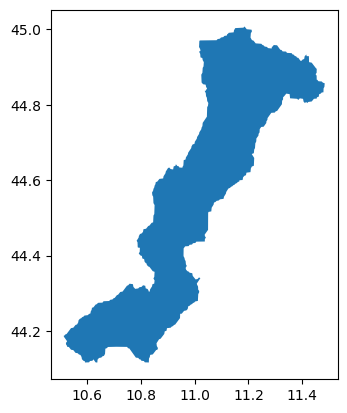

In [11]:
# read watershed shapefiles
def read_watershed_shapefiles(shape_dir, level, wspoint):
    """
    Read watershed shapefiles and extract the shapefile entry that contains a specific point.

    Parameters:
    shape_dir (str): The directory where the shapefiles are located.
    level (str): The level of the shapefiles to read.
    wspoint (Point): The point to analyze.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the shapefile entry that contains the point.
    """
    # Construct the shapefile path
    shapef_path = os.path.join(shape_dir, f"hybas_lake_eu_lev{level}_v1c.shp")

    # Read the shapefile
    shape_gdf = gpd.read_file(shapef_path)

    # Find the shapefile entries that contain the point
    contains_point = shape_gdf['geometry'].contains(wspoint)

    # Extract the shapefile entry that contains the point
    shape_basin_gdf = shape_gdf[contains_point]

    return shape_basin_gdf


def xarray_in_shapefile(xds,varname,latname,lonname,shapef,operation):
    
    # compute average precipitation (ds_emo) for grid points within shape_basin_gdf
    df = xds[varname].to_dataframe()
    lats = df.index.get_level_values(latname)
    lons = df.index.get_level_values(lonname)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs='EPSG:4326')

    # created join dataframe between data and shapefile
    gdf_joined = gpd.sjoin(gdf, shapef, predicate='within')

     # Group by time and region, and sum the values
    if operation=='mean':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].mean()
    elif operation=='sum':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].sum()
    elif operation=='max':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].max()

    # Convert the series to a DataFrame and pivot it
    results_df=pd.DataFrame()
    results_df[varname] = results.reset_index().pivot(index='time', columns='index_right', values=varname)
    results_xds=results_df.to_xarray()

    return results_df, results_xds

# read shape file
shape_basin_gdf=read_watershed_shapefiles(shape_dir, shape_file_level, wspoint)
shape_basin_gdf.plot()


### Compute maximum discharge in watershed (wmax)

In [12]:

# if maximum discharge exists, read it, otherwise compute it
fname_dismax=f"{EFASDIR_HIST}/postpro/watersheds/efas_{region}_{tres}_dis_max.nc"
if os.path.exists(fname_dismax) and ReadExisting:
    xds_max=xr.open_dataset(fname_dismax)
else:
    # read EFAS data
    xds=xr.open_mfdataset(wshed_fname,combine='by_coords')
    xds_max=xds.max(dim=['lat', 'lon'])

    # save to file
    xds_max.to_netcdf(fname_dismax)

ds_max=xds_max[disname].values

<xarray.Dataset> Size: 140kB
Dimensions:      (time: 11687)
Coordinates:
  * time         (time) datetime64[ns] 93kB 1992-01-03 1992-01-04 ... 2024-01-01
    spatial_ref  int64 8B ...
Data variables:
    dis24        (time) float32 47kB dask.array<chunksize=(11687,), meta=np.ndarray>
<xarray.Dataset> Size: 327kB
Dimensions:    (time: 11687, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 93kB 1992-01-03 1992-01-04 ... 2024-01-01
    lon        float64 8B 10.99
    lat        float64 8B 44.66
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 187kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    dis24      (time) float32 47kB dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Jun 12 22:43:01 2024: cdo delete,timestep=1 efas_pan

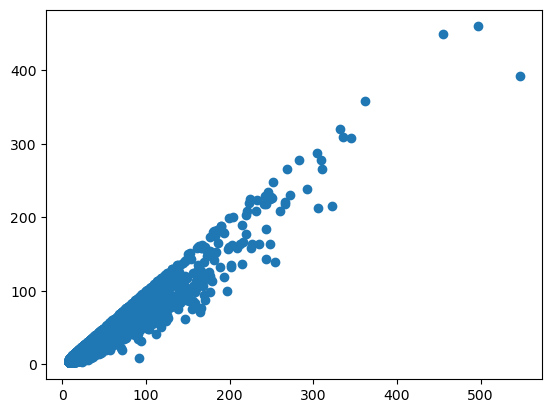

In [13]:
print(xds_max)
print(xds_gp)

plt.scatter(xds_max['dis24'].values, xds_gp['dis24'].values)
plt.show()

# Plot example streamflow map in a given day, with watershed contour

In [14]:
# Plot a map for a day associated with Panaro flooding near Modena
# It would be more efficient if we just read the .nc containing the event (sort by year)
if plot2d_day:   
    #
    dataset2d = xr.open_mfdataset(fname_pat, combine='by_coords')

    # Access variables within the dataset
    time_step = '2013-10-20T18:00:00'  # Example time step
    data2d_day=dataset2d.sel(time=time_step)   
    #variable = dataset2d['dis06'].sel(time=time_step)

    # Extract longitude, latitude, and variable data
    lon, lat, vv = data2d_day['lon'], data2d_day['lat'], data2d_day[disname]

    # Plot the map
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the variable on the map
    plt.pcolormesh(lon, lat, vv, transform=ccrs.PlateCarree(), cmap='viridis',vmin=0,vmax=800)
    plt.xlim(tlon-2, tlon+2)  # Set longitude range
    plt.ylim(tlat-1, tlat+1)  # Set latitude range

    # Add coastlines, gridlines, and title
    ax.coastlines()
    ax.gridlines()
    plt.title(f'Map for {time_step}')
    plt.colorbar(label='discharge')
    plt.show()


    # Plot a map for a day associated with regional flooding
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.pcolormesh(lon, lat, vv, transform=ccrs.PlateCarree(), cmap='viridis',vmin=0,vmax=5)

    # plot the watershed
    shape_gdf.plot(ax=ax, color='none', edgecolor='red')
    if tlabel=='modena':
        plt.xlim([10, 13])  # Approximate longitude of Italy
        plt.ylim([44, 45.5])  # Approximate latitude of Italy
    plt.show()



# Look at time series of streamflow

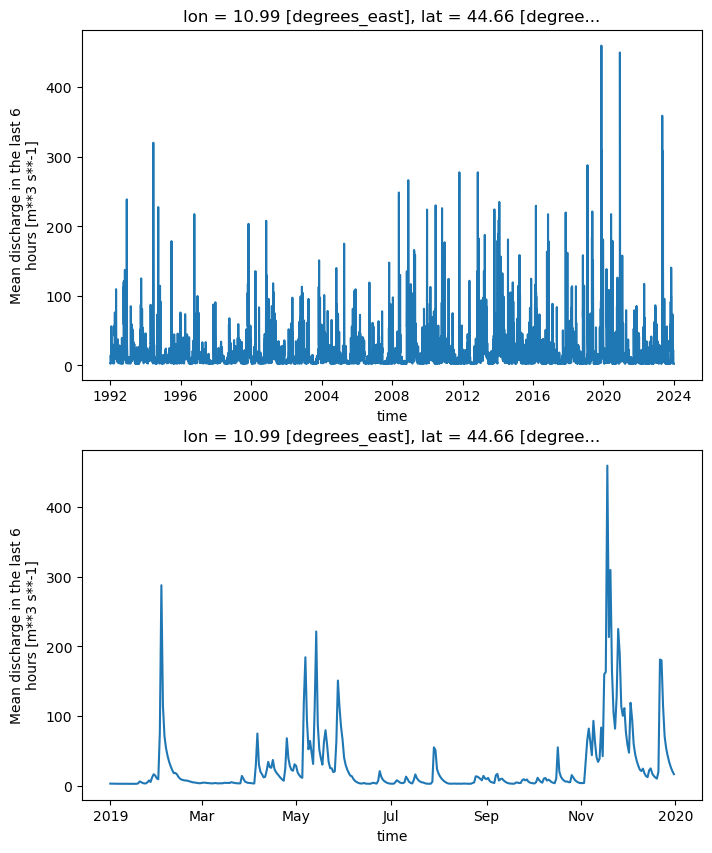

In [15]:

# plot timeseries using xarray 
fig,axs=plt.subplots(2,1,figsize=(8,10))
time_start_plot="1992-01-01"
time_end_plot="2023-12-31"
xds_gp[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[0])
time_start_plot="2019-01-01"
time_end_plot="2019-12-31"
xds_gp[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[1])



### Mean seasonality analyses

/home/zappa/miniforge3/lib/python3.10/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


(0.0, 700.0)

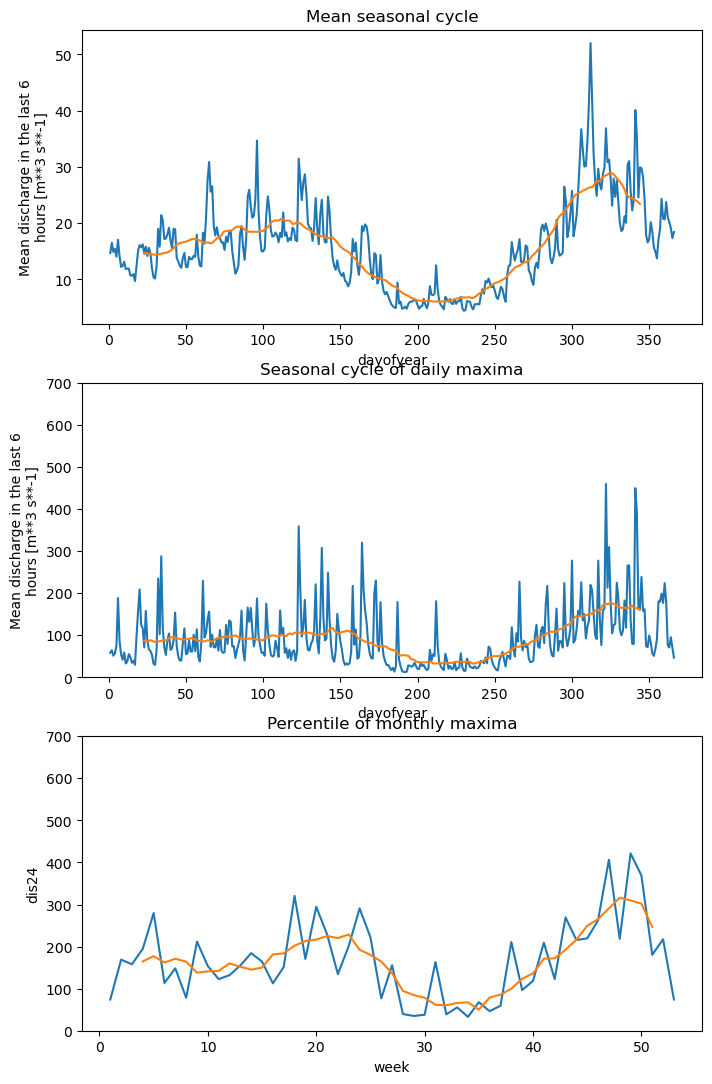

In [16]:
# this is not working, yet
def circular_rolling(da, window_size):
    # Append the start of the DataArray to the end to create a circular buffer
    circular_data = np.concatenate([da, da[:window_size]])

    # Create a new DataArray with the circular buffer
    circular_da = xr.DataArray(circular_data, dims=da.dims, coords=da.coords)

    # Apply the rolling operation
    result = circular_da.rolling({da.dims[0]: window_size}, center=True).mean()

    # Slice off the extra values at the end
    result = result[:len(da)]

    return result


# mean seasonality
daily_means = xds_gp.groupby('time.dayofyear').mean(dim='time')
daily_max = xds_gp.groupby('time.dayofyear').max(dim='time')

percentile_value=99.5 # percentile of extremes values within 1 week window across years
monthly_max = xds_gp.resample(time='1W').max(dim='time').chunk({'time': -1})
monthly_max_p = monthly_max.groupby('time.week').quantile(q=percentile_value / 100, dim='time')
monthly_max_max = monthly_max.groupby('time.month').max(dim='time')

# roolling average
window_size = 45  # Smoothing to highlight mean seasonal cycle
week_size=int(np.round(window_size/7))
smoothed_means = daily_means[disname].rolling(dayofyear=window_size, center=True).mean()
smoothed_max = daily_max[disname].rolling(dayofyear=window_size, center=True).mean()
smoothed_monthly_max = monthly_max_p[disname].rolling(week=week_size, center=True).mean()

# plot stats
plt.figure
fig, axs = plt.subplots(3, 1, figsize=(8, 13))  # 2 rows, 1 column
daily_means[disname].plot(ax=axs[0])
smoothed_means.plot(ax=axs[0])
axs[0].set_title('Mean seasonal cycle')

daily_max[disname].plot(ax=axs[1])
smoothed_max.plot(ax=axs[1])
axs[1].set_title('Seasonal cycle of daily maxima')
axs[1].set_ylim(0, 700)

monthly_max_p[disname].plot(ax=axs[2])
smoothed_monthly_max.plot(ax=axs[2])
axs[2].set_title(f'Percentile of monthly maxima')
axs[2].set_ylim(0, 700)


### Identify extreme events (single grid point)

In [17]:
def find_events(data, prcth, gap=0):
    # data: 1D array of values
    # threshold: threshold value for event detection
    # gap: minimum number of consecutive values below the threshold to consider as a new event

    # define threshold
    threshold=np.percentile(ds_gp, prcth)

    # initialize variables
    events = []
    event_start = None
    event_values = []  # List to store values within each event
    
    # Loop through the data array
    for i, value in enumerate(data):
        if value > threshold:
            # Start of a new event
            if event_start is None:
                event_start = i
            event_values.append(value)
            #print(event_values)
        else:
            # End of an event
            if np.all(data[i:i+gap]<threshold) and event_start is not None:
                events.append((event_start, i-1, event_values))  # Append the event start and end indices
                event_start = None  # Reset event start index
                event_values = []  # Reset event_values    

    # Check if an event extends to the end of the array
    if event_start is not None:
        events.append((event_start, len(data)-1), event_values)  # Append the event start and end indices
    
    return events, threshold


Identify events by maximum water shed discharge


Text(0.5, 1.0, 'Events exceeding 98-ptile, 87.94 m^3/s')

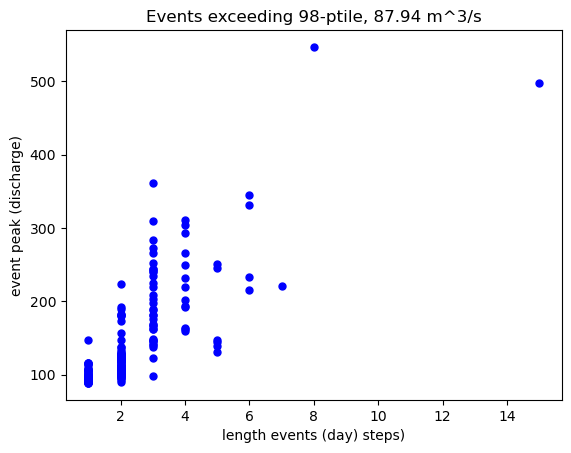

In [18]:
# threshold precentile for event definition (across all timesteps)

# minimum number of time steps below threshold between independent events. Otherwise it's the same event
if tres=='day':
    steps_independent_event=1
elif tres=='6h':
    steps_independent_event=3

prcth=98
if HazardDef=='gp':
    print('Identify events by grid point discharge')
    iv_event,dis_threshold=find_events(ds_gp,prcth,steps_independent_event)
elif HazardDef=='wmax':
    print('Identify events by maximum water shed discharge')
    iv_event,dis_threshold=find_events(ds_max,prcth,steps_independent_event)

# Convert events to a pandas DataFrame
df_events = pd.DataFrame(iv_event)
event_length=df_events[2].apply(len)
event_max=df_events[2].apply(max)

# add column with peak intensity
df_events[3]=event_max

plt.figure
plt.plot(event_length,event_max,marker='o', linestyle='None', markersize=5, color='blue')
plt.xlabel(f'length events ({tres}) steps)')
plt.ylabel('event peak (discharge)')
plt.title(f'Events exceeding {prcth}-ptile, {dis_threshold:,.2f} m^3/s')


### Read ERA data

In [19]:
ERA5dir='/home/zappa/work/ERA5/hourly/'
data_files = {
    ('mean_sea_level_pressure', 'MSL','sfc'),
    ('surface_pressure', 'SP','sfc'),
    ('geopotential','Z','500hPa')
}

years = range(sy, ly+1)

# Loop over each file and variable name
vdata=xr.Dataset()
for variable, variable_name, level_name in data_files:
    if tres=='day':
        erasubdir='day'
        ext=f'day_full_{level_name}_55-55_70_-50_10_55'
        file_paths = f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc"
        ds1 = xr.open_dataset(file_paths)
        ds1=ds1.sel(time=slice(str(sy),str(ly)))
    elif tres=='6h':
        erasubdir='6hrs'
        ext=f'6hrs_full_{level_name}_{{year}}_70_-50_10_55'
        file_paths = [f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc".format(year=year) for year in years]
        ds1 = xr.open_mfdataset(file_paths,combine='by_coords')

    vdata=vdata.assign(**{variable_name: ds1[variable_name]})
    del ds1

### Read EMO data

/home/zappa/work_big/EMO1/pr/panaro/*.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2020.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2022.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2014.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_1991.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2010.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2008.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2021.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2012.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_1990.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_1996.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_1992.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_1995.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2016.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2017.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2000.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2011.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2009.nc
/home/zappa/work_big/EMO1/pr/EMO-1arcmin-pr_2019.nc
/home/zappa/work_big/EM

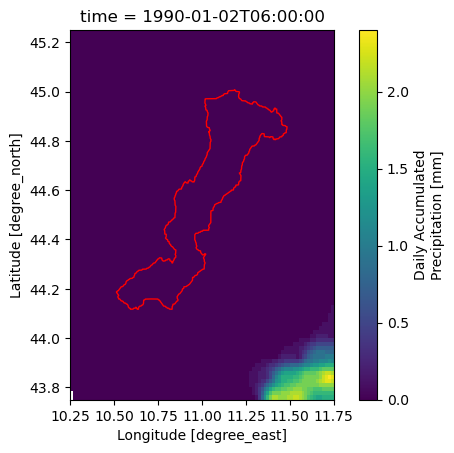

In [20]:
import glob

## for each file in EMO1 ending in .nc, read it and save it to a new file with the same name in the new directory
EMO1dir='/home/zappa/work_big/EMO1'
file_path_out=f"{EMO1dir}/pr/{region}/*.nc"
print(file_path_out)

if glob.glob(file_path_out) and (ReadExisting==True):
    print('already processed')
else:
    for file in glob.glob(f"{EMO1dir}/pr/*.nc"):
        print(file)
        fname=os.path.basename(file)
        ds_emo=xr.open_dataset(file)
        ds_emo=ds_emo.sel(lon=bbox_lon,lat=bbox_lat)
        ds_emo.to_netcdf(f"{EMO1dir}/pr/{region}/{fname}")

xds_emo=xr.open_mfdataset(file_path_out,combine='by_coords')

# inspect data 
xds_emo['pr'].isel(time=0).plot()
shape_basin_gdf.plot(ax=plt.gca(), color='none', edgecolor='red')
plt.show()


### Average precipitation in watershed

In [21]:
# average precip in watershed
df_pr_ws,xds_pr_ws=xarray_in_shapefile(xds_emo,'pr','lat','lon',shape_basin_gdf,'mean')

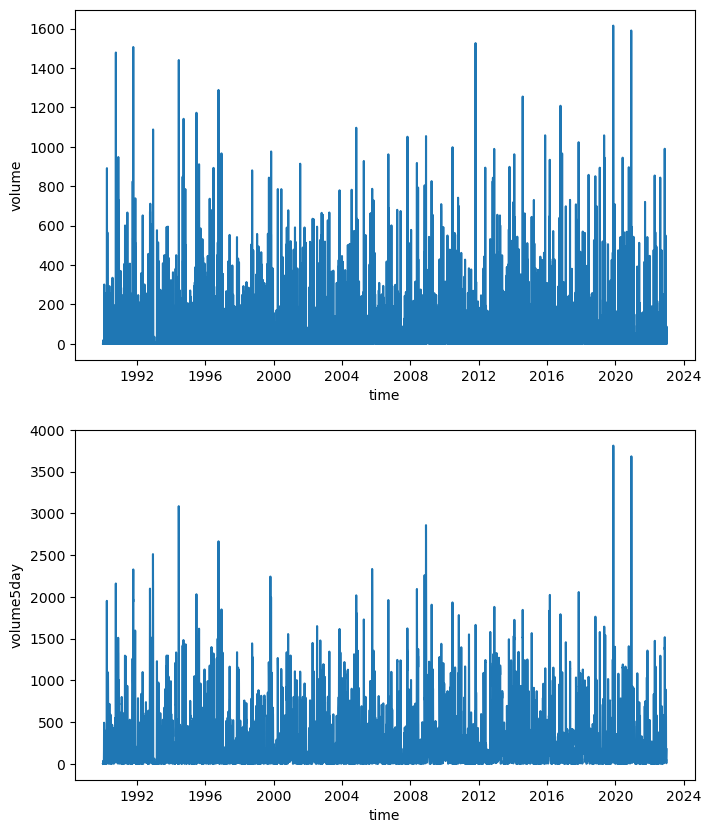

In [22]:

# convert to totol volume of precip
sec_in_day=24*3600
area_m2=shape_basin_gdf['UP_AREA'].values*10**6    # km2 to m2
xds_pr_ws_ms=xds_pr_ws['pr']/1000/sec_in_day       # convert mm/day to m/s
xds_pr_ws_ms['volume'] = area_m2*xds_pr_ws_ms      # and then to m^3/s

# compute 5-day accumulation
xds_pr_ws_ms['volume5day']=xds_pr_ws_ms['volume'].rolling(time=5).sum()

# inspect the data
fig,axs=plt.subplots(2,1,figsize=(8,10))
xds_pr_ws_ms['volume'].plot(ax=axs[0])
xds_pr_ws_ms['volume5day'].plot(ax=axs[1])

Text(0.5, 1.0, 'volume precipitation vs peak discharge')

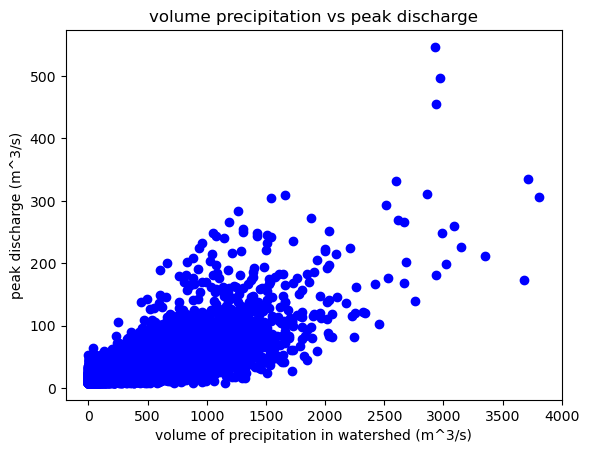

In [44]:
# scatter of volume precipitation vs peak discharge
time_start_plot="1992-01-05"
time_end_plot="2022-12-31"
time_start_volume="1992-01-04"
time_end_volume="2022-12-30"
plt.figure()
plt.scatter(xds_pr_ws_ms['volume5day'].sel(time=slice(time_start_plot,time_end_plot)),xds_max[disname].sel(time=slice(time_start_plot,time_end_plot)),marker='o',color='blue')
#plt.scatter(xds_pr_ws_ms['volume'].sel(time=slice(time_start_volume,time_end_volume)),xds_max[disname].sel(time=slice(time_start_plot,time_end_plot)),marker='o',color='blue')
plt.xlabel('volume of precipitation in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title('volume precipitation vs peak discharge')

Plot SLP + Z500 for individual events

### Save SLP maps for the events

In [24]:

# order events based on peak intensity
df_events_sorted=df_events.sort_values(by=3,axis=0,ascending=False)

# extract days in ERA5
#vdata_events=vdata.isel(time=df_events_sorted[0]) # this is ok, fix due to missing leap days in era daily
tref=xds_gp['time'].isel(time=df_events_sorted[0])
vdata_events=vdata.sel(time=tref.values)

# plot a subset
max_num_plot=20
#vdata_events_plot=vdata.isel(time=df_events_sorted[0][0:max_num_plot]) # this is ok, fix due to missing leap days in era daily
vdata_events_plot=vdata.sel(time=tref.values[0:max_num_plot])

# Determine the number of time steps
num_times = len(vdata_events_plot.time)

# Calculate the number of rows and columns for the subplot grid
num_rows = int(num_times ** 0.5)
num_cols = (num_times + num_rows - 1) // num_rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through each time step and plot in the corresponding subplot
for i, time in enumerate(vdata_events_plot.time):
    row = i // num_cols
    col = i % num_cols

    # 
    data_at_time = vdata_events_plot.sel(time=time)

    # Set contour levels 
    contour_levels_MSL = np.linspace(data_at_time.MSL.min(), data_at_time.MSL.max(), num=10)
    contour_levels_Z500 = np.linspace(data_at_time.Z.min(), data_at_time.Z.max(), num=10)

    # Plot in the corresponding subplot
    ax = axes[row, col]
    ax.set_title(f'{time.values}')
    
    ax.set_extent([-20, 35, 30, 60], crs=ccrs.PlateCarree())  # Set the desired lat/lon range
    im_MSP = ax.contourf(data_at_time['MSL'].lon, data_at_time['MSL'].lat,
                      data_at_time['MSL'], levels=contour_levels_MSL, cmap='viridis', transform=ccrs.PlateCarree())
    im_Z = ax.contour(data_at_time['Z'].lon, data_at_time['Z'].lat,
                      data_at_time['Z'].sel(plev=50000), levels=contour_levels_Z500, cmap='RdBu_r', transform=ccrs.PlateCarree())

    # Add coastlines using Cartopy
    ax.coastlines()

    # Remove color bar
    cbar = fig.colorbar(im_MSP, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
    cbar.remove()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



KeyError: "not all values found in index 'time'"

In [ ]:
def composite_events(vdata, df_events):
    era_events=[]
    for event_start in df_events[0]:
        #print(event_start)
        # Extract data for the event time steps
        era_events_tmp = vdata.isel(time=event_start)
        #print(era_events_tmp.dims)
        # Calculate the average of variable B for the event
        era_events.append(era_events_tmp)
    era_events_concatenated = xr.concat(era_events, dim="event") 
    vdata_clim=vdata.mean(dim='time')
    average_era_events = era_events_concatenated.mean(dim="event")
    average_era_events_anom=average_era_events-vdata_clim

    return average_era_events_anom

## List of variable names you want to extract
#ext='6hrs_full_sfc_{year}_70_-50_10_55'
#data_files = {
#    ('surface_pressure', 'SP')
#}
#years = range(1992, 2024)

# compute composite means... commented: a bit slow become of the anomalies
#comp_mean=composite_events(vdata, df_events)
    

In [ ]:
# print(comp_mean)
# # Plot composite mean anomaly the variable on the map
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Plot the data array
# comp_mean['Z'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# # Add coastlines and gridlines
# ax.coastlines()
# #ax.gridlines()

# # Show the plot
# plt.show()

In [ ]:
from collections import Counter

def train_som(data, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):
    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, data.shape[1], sigma=0.6, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(data, num_epochs)

    # Prediction
    cluster_index = np.array([som.winner(x) for x in data])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    return cluster_index, som

def train_som2(xdata, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):

    # weights
    ww=np.sqrt(np.cos(np.radians(xdata['lat'])))
    xdataw=xdata*ww

    # reshape data to give to minisom
    dd4som_v=xdataw.MSL.values
    dd4som_vr=dd4som_v.reshape(dd4som_v.shape[0],-1)

    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, dd4som_vr.shape[1], sigma=0.5, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(dd4som_vr, num_epochs)

    # get nodes
    wtt=som.get_weights()

    # Prediction
    cluster_index = np.array([som.winner(x) for x in dd4som_vr])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    # reshape before output
    wtt=wtt.reshape(num_neurons_x,num_neurons_y,dd4som_v.shape[1],-1)

    # scale nodes back by area weighting --- to do

    return cluster_index, som, wtt

In [ ]:
# select data for minisom
#dd4som=vdata_events.sel(time=vdata_events.time,lon=slice(-15,30),lat=slice(60,35)).squeeze()
dd4som=vdata_events.sel(lon=slice(-15,30),lat=slice(60,35)).squeeze()
nx=3
ny=2
nn=nx*ny
cli, som1, wtt=train_som2(dd4som,nx,ny)


In [ ]:
def calculate_threshold(som, data, factor=1.0):
    """
    Calculate a distance threshold based on the standard deviation of the distances from each SOM node to the fields associated with it.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    data (numpy.ndarray): The data used to train the SOM.
    factor (float): The factor to multiply the standard deviation by to calculate the threshold.

    Returns:
    float: The distance threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to each field
    distances = np.linalg.norm(weights[:, :, np.newaxis] - data, axis=-1)

    # Calculate the standard deviation of the distances
    std_dev = np.std(distances)

    # Calculate the threshold as a multiple of the standard deviation
    threshold = factor * std_dev

    return threshold


def get_winner_within_threshold(som, input_vector, threshold):
    """
    Get the winning node for an input vector if the distance is below a given threshold.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    input_vector (numpy.ndarray): The input vector.
    threshold (float): The distance threshold.

    Returns:
    tuple: The coordinates of the winning node, or None if no node is within the threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to the input vector
    distances = np.linalg.norm(weights - input_vector, axis=-1)

    # Find the coordinates of the node with the minimum distance
    winning_node = np.unravel_index(distances.argmin(), distances.shape)

    # If the minimum distance is below the threshold, return the coordinates of the winning node
    if distances[winning_node] < threshold:
        return winning_node

    # If no node is within the threshold, return None
    return None

23
[4 2 0 5 2 1 4 0 0 2 3 2 4 1 1 5 5 0 4 1 0 5 4 1 5 0 5 3 2 3 2 4 3 1 5 4 0
 4 4 0 4 4 3 5 4 1 0 3 0 2 2 2 4 2 5 5 4 0 0 1 4 2 1 1 3 4 2 0 3 4 3 4 1 3
 1 0 3 2 1 0 3 2 1 3 0 0 1 1 3 3 4 1 4 0 3 0 3 4 5 5 5 3 0 2 1 0 1 2 1 5 5
 1 4 4 4 1 2 1 3 2 2 5 5 1 5 0 2 0 2 4 4 2 2 1 1 4 2 3 2]
[0 1 2 3 4 5]


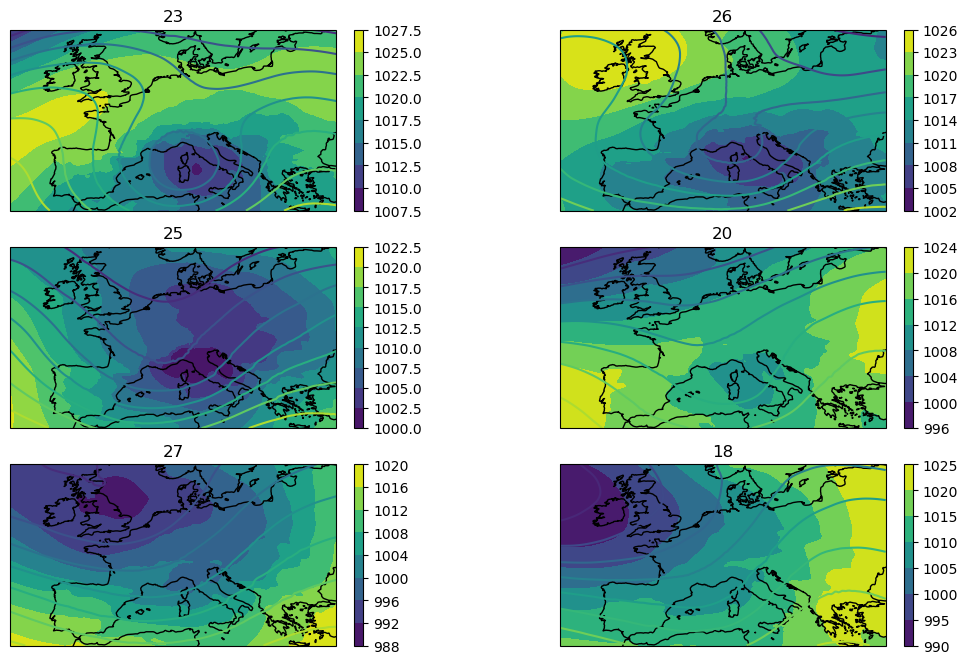

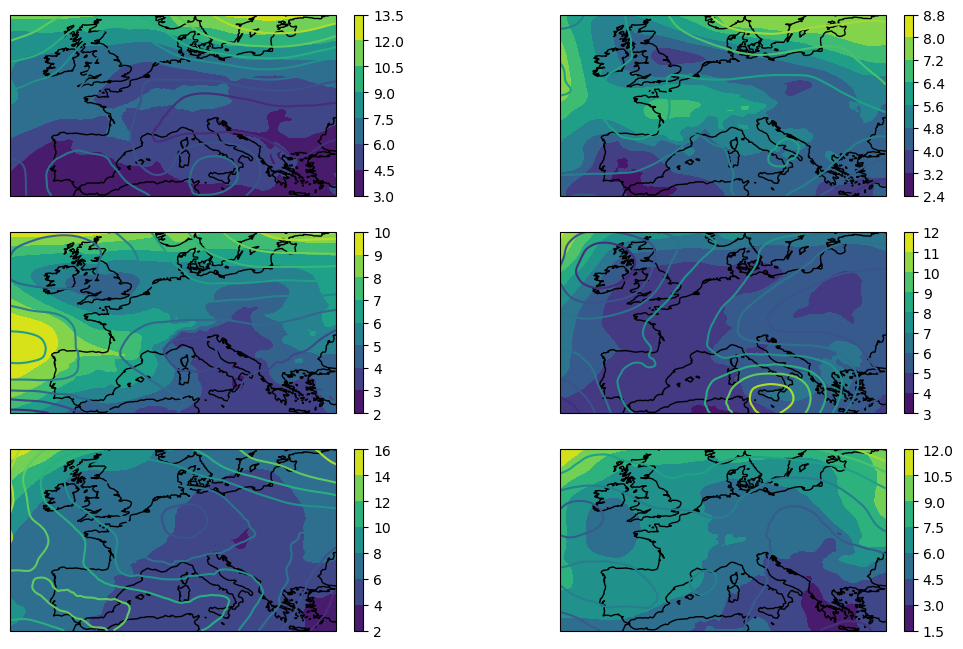

In [ ]:


occurrences=Counter(cli)
print(occurrences[0])

# Initialize an empty array to store mean values

mean_node_MSL = np.zeros((4, dd4som.MSL.values.shape[1], dd4som.MSL.values.shape[2]))
mean_node_Z= np.zeros((4, dd4som.Z.values.shape[1], dd4som.Z.values.shape[2]))

unique=np.unique(cli)
print(cli)
print(unique)

mean_node_MSL = [np.mean(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
mean_node_Z = [np.mean(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_MSL = [np.std(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_Z = [np.std(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]

# Create a Cartopy projection (PlateCarree for geographic data)
projection = ccrs.PlateCarree()

# Create map of mean node
fig, axs = plt.subplots(nx, ny, figsize=(13, 8), subplot_kw={'projection': projection})

for ax, d1, d2, inode in zip(axs.flat, mean_node_MSL, mean_node_Z, range(0,nn)):
    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, transform=projection)
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, transform=projection)

    # Add coastlines
    ax.coastlines()

    # add number of events
    ax.set_title(f"{occurrences[inode]}")

    # Add a colorbar
    cbar = plt.colorbar(cax1,orientation='vertical', fraction=0.05, pad=0.04)
plt.show()

# Create map of std within each node
fig, axs = plt.subplots(nx, ny, figsize=(13, 8), subplot_kw={'projection': projection})

for ax, d1, d2 in zip(axs.flat, std_node_MSL, std_node_Z):
    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, transform=projection)
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, transform=projection)

    # Add coastlines
    ax.coastlines()


    # Add a colorbar
    cbar = plt.colorbar(cax1, orientation='vertical', fraction=0.05, pad=0.04)
plt.show()


(array([ 6574.,  8035.,  9496., 10957., 12418., 13879., 15340., 16801.,
        18262., 19723., 21184.]),
 [Text(6574.0, 0, '1988'),
  Text(8035.0, 0, '1992'),
  Text(9496.0, 0, '1996'),
  Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024'),
  Text(21184.0, 0, '2028')])

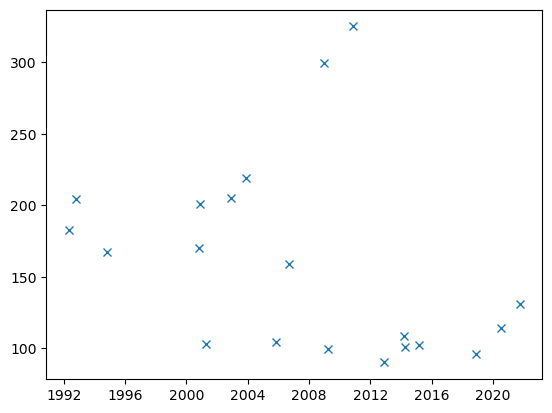

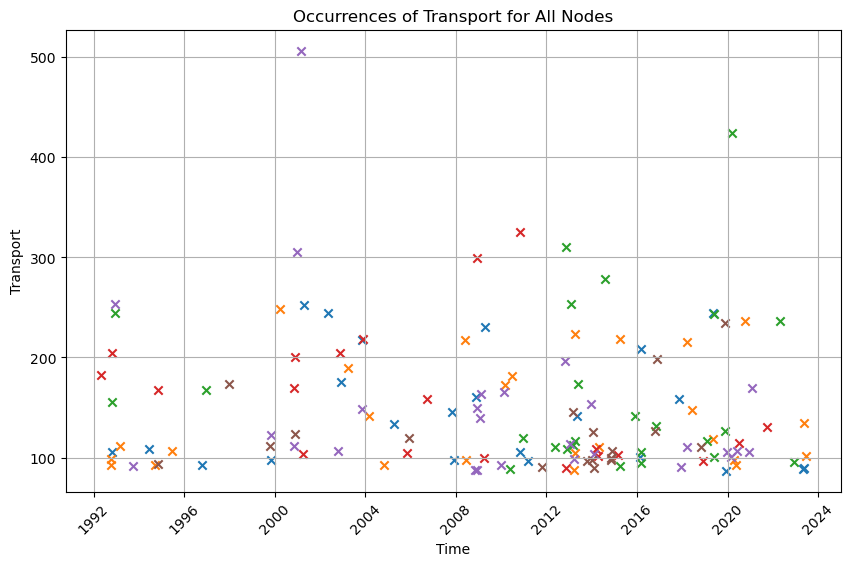

In [ ]:


all_transport_per_class = []
all_time_per_class = []

# Loop over each inode
for inode in range(nn):
    # Filter data for the current inode
    transport_per_class = df_events.loc[cli == inode, [0, 3]]
    time_per_class = dd4som.time[cli == inode]

    # Append the data to the respective lists
    all_transport_per_class.append(transport_per_class)
    all_time_per_class.append(time_per_class)



#plt.plot(all_time_per_class[3].time.values.T)
inode=3
plt.plot(all_time_per_class[inode],all_transport_per_class[inode][3],'x')



# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Iterate over all nodes
for inode in range(len(all_time_per_class)):
    # Extract the time and transport data for the current inode
    time_per_class = all_time_per_class[inode]
    transport_per_class = all_transport_per_class[inode]
    
    # Plot the occurrences for the current inode
    plt.scatter(time_per_class, transport_per_class[3], marker='x', label=f'Node {inode}')

# Add labels and title to the plot
plt.title('Occurrences of Transport for All Nodes')
plt.xlabel('Time')
plt.ylabel('Transport')
plt.grid(True)
plt.xticks(rotation=45)


In [ ]:
#df_events_sorted[0][0:10]
print(slice(30,40))

slice(30, 40, None)


1) Leggere SLP/TCWV/Z500/Precip ERA5 e fare mean composite / SOM clustering (18 eventi?)
2) Guardare stagionalità media portata, accadimento eventi
3) Fittare GEV to Annual maxima ... ma con 30 punti ci facciamo poco.
4) Guardare dipendenza temporale eventi da posizione lungo corso d'acqua
5) Map tendency of annual maxima (Italy)
6) Composite centered-time evolution of event.
7) Pioggia su bacino idrografico / TCWV
8) Dati di stazione (esistono per panaro) 
9) Clusterizzazione su più variabili / utile?
10) Medie per stagione / o cluster alla grazzini su TCWV
11) Correlazione con fiumi limitrofi

-> distrubuzioni portate per cluster
-> Serie temporale cluster / portata media per cluster / trend portata per cluster 

-> realismo distribuzione portata forecasts
-> validare la stagionlità portata media
-> PDF aggregata per stagione
-> Distribuzione eventi che ti passano soglia / distribuzione massimi annuali

Correlazione spaziale piene spaziali di EFAS / composite o regressione usando o tutti i giorni o eventi di piena. Piene panaro sono associate a piene altri fiumi? Come cambia in funzione del regime?

